In [4]:
# Afin de simplifier la comprehension, les notations respectent au mieux celles introduites dans les travaux de Dean Wheeler

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import time

In [5]:
############################## Paramètres ##############################

# Remarque: Seuls les retours & entrées (cette section) utilisateur peuvent utiliser des unités Y[1]ors SI pour simplifier la lecture.
# Les entrées sont ensuites converties en unités SI et toutes les variables et le programme fonctionnent avec des unités SI.

# Simulation
dz = 0.01 # pas (en mm) utilisé pour l'integration du volume de la bouteille, defaut 10µm
dt = 0.1 # pas (en ms) utilisé pour la discretisation du temps (integration & eq diff), defaut 0.1ms

# Bouteille (lorsque l'on parle de la la bouteille, est a comprendre la chambre de pression & la tuyère)
Vb = 1 # volume (en L) de la bouteille
Rb = 40 # rayon (en mm)  de la bouteille
Rt = 4.5 # rayon (en mm) de la tuyere 
z_ret = 110 # hauteur (en mm) du rétrécissement de la bouteille (ie debut tuyère - début corps droit)
mb = 100 # masse a vide (en g) de la bouteille
Cd = 0.5 # coef de trainée (sans unité)

# Remplissage & pression
p0 = 7 # surpression de remplissage de la bouteille (en bar)
Vw0 = 0.5 # volume (en L) initial du liquide de propulsion (eau) - doit être < volume_bouteille

# Lanceur
R_TO = 4 # rayon (en mm) extérieur du tube de lancement
R_TI = 3 # rayon (en mm) intérieur du tube de lancement
L_T = 200 # longueur (en mm) du tube de lancement
Vl = 0.5 # volume (en L) du lanceur

# Environnement
T0 = 25 # temperature (en °C)
P_atm = 1.01325 # pression atmosphérique (en bar)

In [6]:
############################## Conversion SI & Constantes ##############################

# Conversions SI
dz /= 1000
dt /= 1000
Vb /= 1000
Rb /= 1000
Rt /= 1000
z_ret /= 1000
mb /= 1000
p0 *= 100000
Vw0 /= 1000
T0 += 273.15
P_atm *= 100000
R_TO /= 1000
R_TI /= 1000
L_T /= 1000
Vl /= 1000

P0 = p0 + P_atm

# Constantes
rho_w = 1000 # 999.972 kg/m^3 pour l'eau
R_GP = 8.31 # 8.3144621 J/K/mol - constante gazs parfaits
M_air = 0.029 # 28.965 g/mol - masse molaire air (en kg/mol)
rho_air = 1.292*273.15/T0 # 1.292 kg/m^3 pour T=0°C au niveau de la mer (GP, P*M/R=cste)
gamma_air = 1.4 # Indice adiabatique air
g = 9.8 # 9.80665 m/s^2 (conference poids & mesures 1901) - Acceleration de la pesanteur à la surface de la terre 

In [7]:
############################## R(z), A(z) ##############################

# Referentiel Bouteille - z est la distance axiale par rapport à la sotrie de la tuyère (flux supposé unidirectionnel)

z_goulot = 0.26*z_ret # z auquel le goulot se termine

# Renvoie le rayon a z donné - basé sur puis arctan entre -param_tan et param_tan et 
def R(z):
  param_tan = 1.8 # meilleurs parametres trouvés pour correspondre a mes bouteilles
  if z>=z_ret:
    return Rb
  elif z<=z_goulot:
    return Rt
  else:
    z_atan = param_tan*(2*(z-z_goulot)/(z_ret-z_goulot)-1)
    return Rt + (Rb-Rt)/2 * (1+np.arctan(z_atan)/np.arctan(param_tan))

# Renvoie la section a z donné
def A(z):
  return np.pi*R(z)**2

# Test courbe rétrécissement
# plt.plot([R(z) for z in np.linspace(0,z_ret,100)])
# plt.show()

In [13]:
############################## UNUSED - FUNCTION OBJECT init bouteille H(Vw,e), rho(z), m_tot(H), Vw(H) ##############################
"""
# Methode fonctionelle avec scipy

V_ret = integrate.quad(A, 0, z_ret)[0] # volume (en m^3) de z=0 a z=z_ret
print(f"V_ret = {round(V_ret*1000, 3)} L (volume de z=0 à z=z_ret={z_ret*1000} mm)")
z_max = (Vb-V_ret)/(np.pi*Rb**2) + z_ret # hauteur (en m) de la bouteille
print(f"Donc z_max={round(z_max*100, 1)}cm (hauteur totale bouteille)")

# Renvoie H, hauteur de liquide avec une précision e
# pour une volume de liquide V donné par recherche par dichotomie sur V
def H(Vw,e):
  def f(z):
    return integrate.quad(A, 0, z)[0]-Vw
  a,b = 0,z_max
  while (f(b)-f(a))>e:
    m = (a+b)/2
    if f(m)*f(b)>0:
      b = m
    else:
      a = m
  return m,f(m)
H0 = H(Vw0,10e-4)[0] # H(t) hauteur interface air-liquide

# Renvoie rho à z & H donnés
def rho(z,H):
  if z>=H:
    return rho_air
  else:
    return rho_w

# Masse linéique axiale rho(z,H)*A(z)
def dm(z,H):
  return rho(z,H)*A(z)

# Renvoie la masse totale de la fusée à H donné
def m_tot(H):
  return mb + integrate.quad(dm, 0, z_max, args=(H))[0]

# Renvoie le volume de liquide dans la fusée à H donné
def Vw(H):
  return integrate.quad(dm, 0, H, args=(H))[0]
"""

"""
# UNUSED - Intégrale du rayon entre a et b (objectif était le volume mais expression analytique trop complexe)
def R_int(a,b):
  param_tan = 1.8 # meilleurs parametres trouvés pour correspondre a mes bouteilles
  z_goulot = 0.26*z_ret
  # Primitive de R
  def G(z):
    a = -(z_ret-z_goulot)*np.log((param_tan**2+1)*(z_ret**2+z_goulot**2)+2*z_ret*z_goulot*(param_tan**2-1)+4*param_tan**2*z*(z-z_goulot-z_ret))
    b = 2*param_tan*(z_ret+z_goulot-2*z)*np.arctan(param_tan*(z_ret+z_goulot-2*z)/(z_ret-z_goulot))
    c = (Rb+Rt)*z/2
    return (Rb-Rt)*(a+b) + c
  return(G(b)-G(a))
"""

'\n# Methode fonctionelle avec scipy\n\nV_ret = integrate.quad(A, 0, z_ret)[0] # volume (en m^3) de z=0 a z=z_ret\nprint(f"V_ret = {round(V_ret*1000, 3)} L (volume de z=0 à z=z_ret={z_ret*1000} mm)")\nz_max = (Vb-V_ret)/(np.pi*Rb**2) + z_ret # hauteur (en m) de la bouteille\nprint(f"Donc z_max={round(z_max*100, 1)}cm (hauteur totale bouteille)")\n\n# Renvoie H, hauteur de liquide avec une précision e\n# pour une volume de liquide V donné par recherche par dichotomie sur V\ndef H(Vw,e):\n  def f(z):\n    return integrate.quad(A, 0, z)[0]-Vw\n  a,b = 0,z_max\n  while (f(b)-f(a))>e:\n    m = (a+b)/2\n    if f(m)*f(b)>0:\n      b = m\n    else:\n      a = m\n  return m,f(m)\nH0 = H(Vw0,10e-4)[0] # H(t) hauteur interface air-liquide\n\n# Renvoie rho à z & H donnés\ndef rho(z,H):\n  if z>=H:\n    return rho_air\n  else:\n    return rho_w\n\n# Masse linéique axiale rho(z,H)*A(z)\ndef dm(z,H):\n  return rho(z,H)*A(z)\n\n# Renvoie la masse totale de la fusée à H donné\ndef m_tot(H):\n  return m

In [14]:
############################## DISCRETISATION initialisation bouteille, H(Vw), Vw(H) ##############################

# Methode simpson & discretisation z
# Renvoie les tableaux de z, A(z) & V(z) en partant de 0 discretisés, ainsi que V_ret & z_max
def init_bouteille():
  # Calculs avant rétrécissement
  z_tab1 = np.arange(0,z_ret+dz,dz)
  A_tab1 = np.array([A(z) for z in z_tab1])
  V_tab1 = integrate.cumulative_simpson(A_tab1,dx=dz) # tableau des volumes, V[i] = volume entre 0 et z_tab1[i]

  # V_ret & z_max
  V_ret = V_tab1[-1] # volume (en m^3) de z=0 a z=z_ret
  z_max = (Vb-V_ret)/(np.pi*Rb**2) + z_ret # hauteur (en m) de la bouteille

  # Calculs après rétrécissement
  z_tab2 = np.arange(z_ret+dz,z_max+dz,dz)
  A_tab2 = np.array([A(z) for z in z_tab2])
  V_tab2 = [np.pi*Rb**2*(z-z_ret)+V_tab1[-1] for z in z_tab2]

  z_tab = np.concatenate((z_tab1,z_tab2))
  A_tab = np.concatenate((A_tab1,A_tab2))
  V_tab = np.concatenate((V_tab1,V_tab2))

  return (z_tab,A_tab,V_tab,V_ret,z_max)

z_tab,A_tab,V_tab,V_ret,z_max = init_bouteille()
print(f"Nombre d'elements dans z_tab (utilisés pour les integrations): {len(z_tab)}")
print(f"V_ret = {round(V_ret*1000, 3)} L (volume de z=0 à z=z_ret={z_ret*1000} mm)")
print(f"Donc z_max={round(z_max*100, 1)}cm (hauteur totale bouteille)")

# print(V_ret)
#print(integrate.quad(A, 0, z_ret,epsabs=1e-12)[0])

# Renvoie l'indice de l'element le plus proche de e dans une liste de flotants L donnée
def nearest(L,e):
  a,b=0,len(L)
  while len(L[a:b])>2:
    m = (a+b)//2
    if L[m]>=e:
      b = m
    else:
      a = m
  if (L[a]-e)>(L[b]-e):
    return b
  else:
    return a

# Renvoie l'indice dans z_tab de l'element le plus proche de H & |V(H)-Vw|
# pour un volume de liquide Vw donné par recherche par dichotomie dans V_tab
def H(Vw):
  i = nearest(V_tab,Vw)
  return i,abs(V_tab[i]-Vw)

H0 = z_tab[H(Vw0)[0]] # H0 hauteur initiale interface air-liquide

# Renvoie le volume de liquide dans la fusée à H donné
def Vw(H):
  i_H = nearest(z_tab,H)
  return V_tab[i_H]

Nombre d'elements dans z_tab (utilisés pour les integrations): 27585
V_ret = 0.166 L (volume de z=0 à z=z_ret=110.0 mm)
Donc z_max=27.6cm (hauteur totale bouteille)


In [21]:
############################## Phase tube de lancement (noté LT, pour Launch Tube) ##############################

# On note avec un 0 les valeurs des variables à t=0, début de cette phase

t0 = 0
y0 = 0
v0 = 0

# Referentiel Terrestre - y est la distance verticale entre le sol et la fusée (vol supposé purement vertical)
t_LT = [t0] # tableau des temps pour la phase du launch tube
y_LT = [y0] # tableau representant y(t) (altitude fusée) pour la phase du launch tube
v_LT = [v0] # v(t)
a_LT = [] # a(t)

A_TO = np.pi*R_TO**2 # section ext tube lancement
A_TI= np.pi*R_TI**2 # section int tube lancement

rho0 = P0*M_air/R_GP/T0  # masse volumique air dans la bouteille avant lancement
                      # (temps entre pressurisation & lancement assez grand pour que T(air dans la bouteille) = T0)
Vinit = Vl + Vb - Vw0 - L_T*(A_TO-A_TI) # Volume initial de gaz (bouteille+lanceur)
m0 = mb + rho_w*(Vb-Vw0) + rho0*Vinit

# Resolution eq diff en y(t) jusqu'a ce que y = L_T

def f_LT(t,Y):
  d2y_dt = -g + A_TO/m0*(P0*(Vinit/(Vinit+Y[0]*A_TO))**gamma_air - P_atm)
  return (Y[1],d2y_dt)
Y0 = [y_LT[0], v_LT[0]]  # Conditions initiales, y(0)=v(0)=0

a_LT.append(f_LT(t0,Y0)[1]) # 1ère valeur acceleration à t0+

sol = integrate.RK45(f_LT, t_LT[0], Y0, np.inf, max_step=dt, rtol=1e10, atol=1e10) # Initialisation du solveur (Runge-Kutta d'ordre 4)
# erreurs suffisement grandes pour que le facteur limitant soit le max_step

# Résoudre & remplir les listes
while sol.status == 'running' and y_LT[-1] < L_T:
    sol.step() # Faire un pas de dt
    t_LT.append(round(sol.t,int(np.log10(1/dt))))
    y_LT.append(sol.y[0])
    v_LT.append(sol.y[1])
    a_LT.append(f_LT(sol.t,sol.y)[1])

# for i in range(10):
#   print(t_LT[i], y_LT[i])

# Test courbe launch tube
# plt.plot(y_LT)
# plt.plot(v_LT)
# plt.plot(a_LT)
# plt.show()

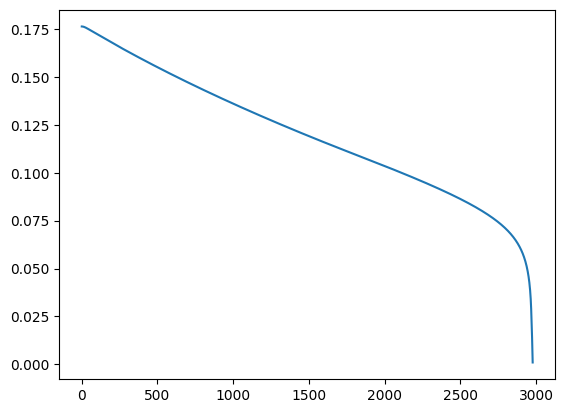

In [36]:
############################## Phase ejection liquide (noté WI, pour Water Impulse) ##############################

# On note avec un 1 les valeurs des variables à t=t1, début de cette phase

t1 = t_LT.pop()
y1 = y_LT.pop()
v1 = v_LT.pop()
a1 = a_LT.pop()
u1 = 0
H1 = H0 # le liquide de propulsion de s'échappe pas de la bouteille dans la phase du launch tube

t_WI = [t1] # tableau des temps pour la phase de propulsion liquide
y_WI = [y1] # tableau representant y(t) (altitude fusée) pour la phase de propulsion liquide
v_WI = [v1] # v(t)
a_WI = [a1] # a(t)
u_WI = [u1] # tableau des vitesses d'ejection u_out pour la phase de propulsion liquide
H_WI = [H1] # H(t)

rho1 = rho0*Vinit/(Vinit+L_T*A_TO)
P1 = P0*(rho1/rho0)**gamma_air # Lois de Laplace
A_out = A(0)

# Renvoie la masse du système {fusée} à H donné
def m_tot_WI(H):
    return mb + rho1*(Vb-Vw0) + rho_w*Vw(H)

# Renvoie B_tab, contenant les valeurs de B(H) pour une table A_tab contenant les sections A(H) donnée
def init_B_WI(A_tab):
  integrand_tab = A_out*np.reciprocal(A_tab) # A(z) --> A_out/A(z)
  B_tab = integrate.cumulative_simpson(integrand_tab,dx=dz)
  return B_tab
B_tab = init_B_WI(A_tab)

# Renvoie la valeur de B (cf expressions benchtop) pour H donné
def B_WI(H):
   i = nearest(z_tab,H)
   return B_tab[i]

# Renvoie la valeur de C (cf expressions benchtop) pour H donné
def C_WI(H):
   return 1/2*((A_out/A(H))**2-1)

# Renvoie la valeur de D (cf expressions benchtop) pour H donné
def D_WI(H):
   return ((Vb-Vw0)/(Vb-Vw(H)))**gamma_air

# Resolution sys diff en u(t) & H(t) jusqu'a ce que H = 0

def f_WI(t,Y):
  e = rho_w*A_out/m_tot_WI(Y[1])*Y[0]**2*(1-A_out/A(Y[1]))
  f = 1/(m_tot_WI(Y[1])*Y[1])*((P_atm-D_WI(Y[1])*P1)/rho_w - C_WI(Y[1])*Y[0]**2)
  g = (rho_w*A_out*Y[1]**2 - B_WI(Y[1]))/(Y[1]*m_tot_WI(Y[1]))
  du_dt = (e-f)/g # e,f,g introduits pour la lisibilité
  dH_dt = A_out/A(Y[1]) * Y[0]
  return (du_dt,dH_dt)

Y1 = [u_WI[0], H_WI[0]]  # Conditions initiales, u(t1)=0 & H(t1)=H0
sol = integrate.RK45(f_WI, t_WI[0], Y1, np.inf, max_step=dt, rtol=1e10, atol=1e10)

# Résoudre & remplir les listes
while sol.status == 'running' and H_WI[-1] > 0:
    sol.step() # Faire un pas de dt
    t_WI.append(round(sol.t,int(np.log10(1/dt))))
    u_WI.append(sol.y[0])
    H_WI.append(sol.y[1])

# Supprimer dernier element aberant
t_WI.pop()
u_WI.pop()
H_WI.pop()

# for i in range(1,6):
#  print(t_WI[-i], u_WI[-i], H_WI[-i])

# Test courbe water impulse
# plt.plot(u_WI)
plt.plot(H_WI)
# plt.plot(y_WI)
# plt.plot(v_WI)
# plt.plot(a_WI)
plt.show()

In [12]:
############################## 4 Later ##############################

u = "hum" # u(z,t) vitesse axiale fluide/bouteille

# Renvoie la norme de la force de trainée
def F_drag(Cd,rho,A,v):
  return 1/2*Cd*rho*A*v**2

# Renvoie la norme de la force de poussée
def F_thrust():
  return "hum"